<a href="https://colab.research.google.com/github/TuongHoangTy/Hybrid-Quantum-Pneumonia-Detection/blob/main/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pennylane

In [3]:
# ==============================================================================
# CELL 1: KHỞI TẠO MÔI TRƯỜNG & THƯ VIỆN LƯU TRÊN DRIVE
# ==============================================================================
import os
import sys
from google.colab import drive

# 1. Mount Google Drive
print("🔄 Đang kết nối Google Drive...")
drive.mount('/content/drive')

# 2. Cấu hình đường dẫn lưu thư viện (Để không phải cài lại mỗi lần tắt máy)
# Thư mục này nằm trên Drive của em
lib_path = '/content/drive/MyDrive/ReseacherAboutQuantumComputer/1-Article/Library'
os.makedirs(lib_path, exist_ok=True)

# Thêm đường dẫn này vào hệ thống để Python nhận diện
if lib_path not in sys.path:
    sys.path.append(lib_path)
    print(f"✅ Đã thêm {lib_path} vào biến môi trường.")

# 3. Kiểm tra và cài đặt PennyLane
try:
    import pennylane as qml
    print(f"🎉 PennyLane v{qml.version()} đã sẵn sàng!")
except ImportError:
    print("⬇️ Đang cài đặt PennyLane vào Drive (Chỉ mất thời gian lần đầu)...")
    # Cài đặt trực tiếp vào thư mục trên Drive
    !pip install --target=$lib_path pennylane

    # Reload lại site-packages để nhận diện thư viện mới cài
    import site
    import importlib
    importlib.reload(site)

    import pennylane as qml
    print("✅ Cài đặt hoàn tất! Từ lần sau chỉ cần Mount Drive là dùng được.")

SyntaxError: invalid syntax (ipython-input-3474098955.py, line 231)

In [ ]:
import torch
print(torch.cuda.is_available())
# Nếu ra True -> Có GPU (Ngon lành)
# Nếu ra False -> Vẫn đang là CPU (Cần restart runtime)

False


🚀 Running on device: cuda:0
📂 Dữ liệu lấy từ: /content/drive/MyDrive/ReseacherAboutQuantumComputer/1-Article/Train/chest_xray/chest_xray
💾 Checkpoint sẽ lưu tại: /content/drive/MyDrive/ReseacherAboutQuantumComputer/Checkpoints/hybrid_advanced_checkpoint.pth
✅ Dữ liệu sẵn sàng: {'train': 5216, 'val': 624}
Classes: ['NORMAL', 'PNEUMONIA']
🔄 Tìm thấy file checkpoint: /content/drive/MyDrive/ReseacherAboutQuantumComputer/Checkpoints/hybrid_advanced_checkpoint.pth
✅ Đã khôi phục thành công! Trạng thái: Đã xong Epoch 40

🎉 CHÚC MỪNG! Mô hình đã hoàn tất 40 Epochs trước đó.
⏩ Đang chuyển thẳng sang bước vẽ biểu đồ và đánh giá...

📊 ĐANG TẠO BÁO CÁO KẾT QUẢ...


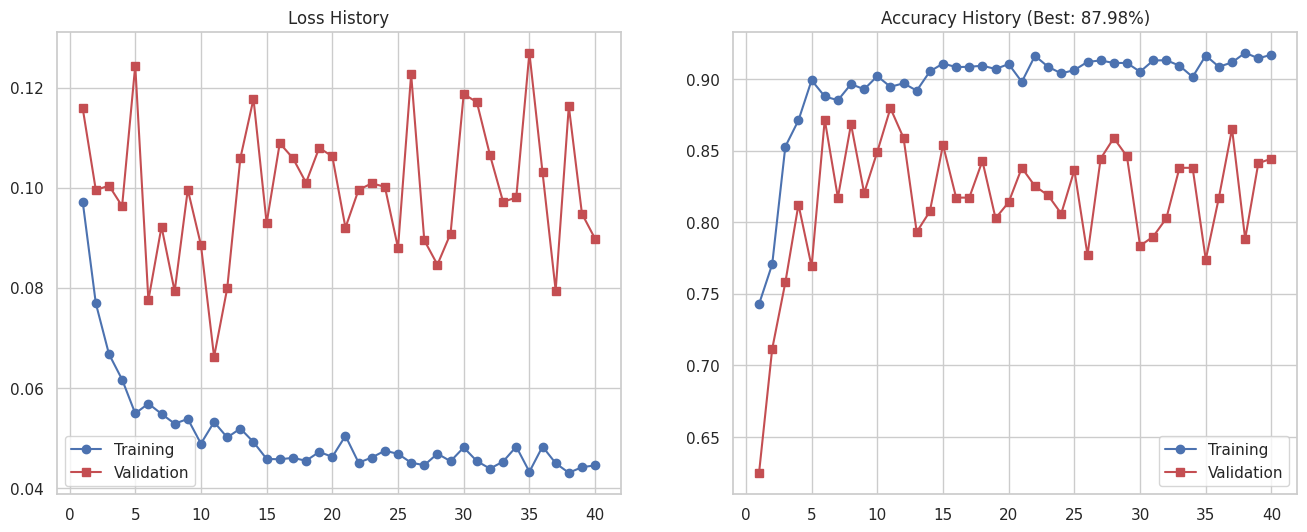


🔄 Đang tính toán Confusion Matrix (Chờ xíu)...


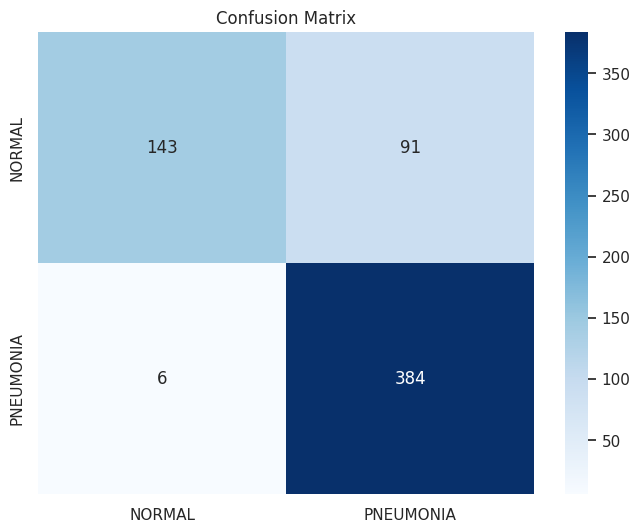


📑 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      NORMAL     0.9597    0.6111    0.7467       234
   PNEUMONIA     0.8084    0.9846    0.8879       390

    accuracy                         0.8446       624
   macro avg     0.8841    0.7979    0.8173       624
weighted avg     0.8652    0.8446    0.8349       624



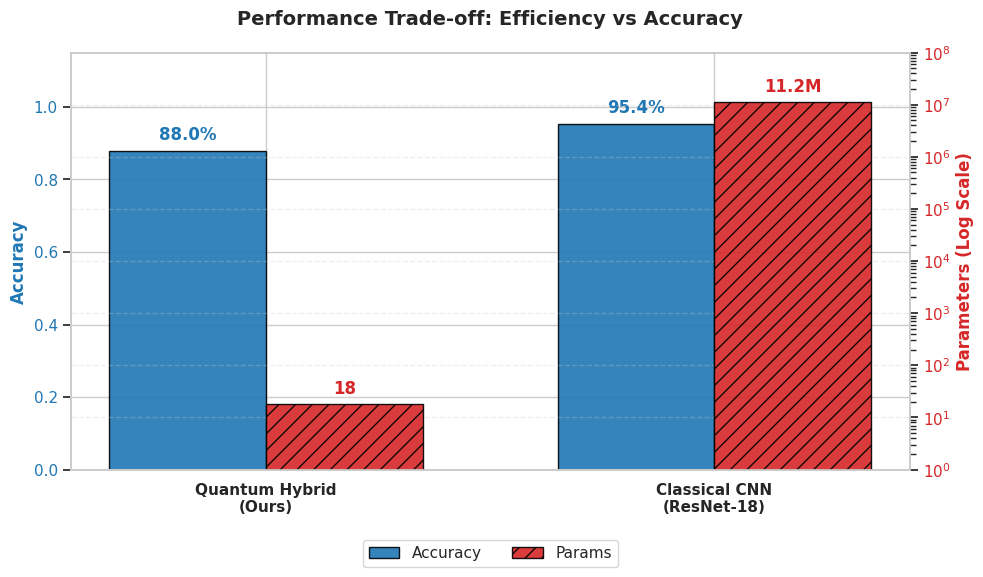

In [5]:
# ==============================================================================
# CELL 2: LOGIC CHÍNH - HYBRID MODEL, TRAINING & CHECKPOINT
# ==============================================================================

# 1. IMPORT THƯ VIỆN & CẤU HÌNH STYLE
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import pennylane as qml
from sklearn.metrics import confusion_matrix, classification_report

# Cấu hình style biểu đồ cho đẹp
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# Cấu hình thiết bị (Tự động nhận diện)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on device: {device}")

# 2. CẤU HÌNH DỮ LIỆU & ĐƯỜNG DẪN CHECKPOINT
checkpoint_dir = '/content/drive/MyDrive/ReseacherAboutQuantumComputer/Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'hybrid_advanced_checkpoint.pth')
data_dir = '/content/drive/MyDrive/ReseacherAboutQuantumComputer/1-Article/Train/chest_xray/chest_xray'

print(f"📂 Dữ liệu lấy từ: {data_dir}")
print(f"💾 Checkpoint sẽ lưu tại: {checkpoint_path}")

# --- Data Augmentation ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(10),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Load Data ---
try:
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'val': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])
    }
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    print(f"✅ Dữ liệu sẵn sàng: {dataset_sizes}")
    print(f"Classes: {class_names}")
except Exception as e:
    print(f"❌ LỖI LOAD DỮ LIỆU: {e}")

# 3. ĐỊNH NGHĨA LOSS & MẠCH LƯỢNG TỬ
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha; self.gamma = gamma
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()

n_qubits = 4; n_layers = 2
dev = qml.device("default.mixed", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net(inputs, weights_y, weights_z):
    for _ in range(2): # Data Re-uploading
        scaled_inputs = torch.pi * torch.tanh(inputs)
        qml.AngleEmbedding(scaled_inputs, wires=range(n_qubits), rotation='X')
        for layer in range(n_layers):
            for q in range(n_qubits):
                qml.RY(weights_y[layer, q], wires=q)
                qml.RZ(weights_z[layer, q], wires=q)
            for q in range(n_qubits-1): qml.CNOT(wires=[q, q+1])
            qml.CNOT(wires=[n_qubits-1, 0])
        qml.DepolarizingChannel(0.01, wires=0)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# 4. MÔ HÌNH HYBRID
class QuantumTransferModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(weights='IMAGENET1K_V1')
        for param in self.base_model.parameters(): param.requires_grad = False
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, n_qubits)
        weight_shapes = {"weights_y": (n_layers, n_qubits), "weights_z": (n_layers, n_qubits)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_net, weight_shapes)
        self.classifier = nn.Linear(n_qubits, 2)
    def forward(self, x):
        return self.classifier(self.quantum_layer(self.base_model(x)))

model_hybrid = QuantumTransferModel().to(device)
criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_hybrid.parameters()), lr=0.0004)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# 5. HÀM CHECKPOINT THÔNG MINH
def load_checkpoint_safe(model, optimizer, filename):
    if os.path.isfile(filename):
        print(f"🔄 Tìm thấy file checkpoint: {filename}")
        try:
            checkpoint = torch.load(filename, map_location=device)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            epoch = checkpoint['epoch']
            best_acc = checkpoint['best_acc']
            history = checkpoint.get('history', {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]})
            print(f"✅ Đã khôi phục thành công! Trạng thái: Đã xong Epoch {epoch + 1}")
            return epoch + 1, best_acc, history
        except Exception as e:
            print(f"⚠️ File lỗi ({e}). Sẽ train lại từ đầu.")
            return 0, 0.0, {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    else:
        print("🚀 Không thấy checkpoint cũ. Bắt đầu training mới.")
        return 0, 0.0, {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

# 6. LOGIC ĐIỀU KHIỂN LUỒNG
start_epoch, best_acc, history = load_checkpoint_safe(model_hybrid, optimizer, checkpoint_path)
num_epochs = 40
accumulation_steps = 8

if start_epoch < num_epochs:
    print(f"\n▶️ BẮT ĐẦU TRAINING TIẾP TỪ EPOCH {start_epoch}...")
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}', end=' ')
        for phase in ['train', 'val']:
            if phase == 'train': model_hybrid.train()
            else: model_hybrid.eval()
            running_loss = 0.0; running_corrects = 0; optimizer.zero_grad()
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model_hybrid(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        (loss / accumulation_steps).backward()
                        if (i + 1) % accumulation_steps == 0: optimizer.step(); optimizer.zero_grad()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train': scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            if phase == 'val' and epoch_acc > best_acc: best_acc = epoch_acc.item()
            print(f'| {phase} Acc: {epoch_acc:.4f}', end=' ')
        print(f'| Best: {best_acc:.4f}')
        torch.save({'epoch': epoch, 'state_dict': model_hybrid.state_dict(),
                    'optimizer': optimizer.state_dict(), 'best_acc': best_acc, 'history': history}, checkpoint_path)
    print("\n✅ Training hoàn tất!")
else:
    print("\n🎉 CHÚC MỪNG! Mô hình đã hoàn tất 40 Epochs trước đó.")
    print("⏩ Đang chuyển thẳng sang bước vẽ biểu đồ và đánh giá...")

# 7. VẼ BIỂU ĐỒ & ĐÁNH GIÁ (UPDATED: ĐẸP & CHUẨN PAPER)
print("\n📊 ĐANG TẠO BÁO CÁO KẾT QUẢ...")

# Learning Curves
epochs = range(1, len(history['train_loss']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(epochs, history['train_loss'], 'b-o', label='Training'); ax1.plot(epochs, history['val_loss'], 'r-s', label='Validation')
ax1.set_title('Loss History'); ax1.legend(); ax1.grid(True)
ax2.plot(epochs, history['train_acc'], 'b-o', label='Training'); ax2.plot(epochs, history['val_acc'], 'r-s', label='Validation')
ax2.set_title(f'Accuracy History (Best: {best_acc:.2%})'); ax2.legend(); ax2.grid(True)
plt.show()

# Confusion Matrix
print("\n🔄 Đang tính toán Confusion Matrix (Chờ xíu)...")
model_hybrid.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix'); plt.show()

print("\n📑 CLASSIFICATION REPORT:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# --- COMPARATIVE PLOT (NEW & IMPROVED) ---
models_name = ['Quantum Hybrid\n(Ours)', 'Classical CNN\n(ResNet-18)']
# Dữ liệu
accuracy = [best_acc, 0.9542] # Lấy từ thực tế và SOTA
params = [18, 11176512]       # 18 params vs 11 triệu

x = np.arange(len(models_name))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Cột Xanh (Accuracy) - Trục Trái
color1 = '#1f77b4'
rects1 = ax1.bar(x - width/2, accuracy, width, label='Accuracy', color=color1, alpha=0.9, edgecolor='black')
ax1.set_ylabel('Accuracy', color=color1, fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1.15); ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(x); ax1.set_xticklabels(models_name, fontweight='bold')

# Cột Đỏ (Params) - Trục Phải
ax2 = ax1.twinx()
color2 = '#d62728'
rects2 = ax2.bar(x + width/2, params, width, label='Params', color=color2, alpha=0.9, edgecolor='black', hatch='//')
ax2.set_ylabel('Parameters (Log Scale)', color=color2, fontsize=12, fontweight='bold')
ax2.set_yscale('log'); ax2.set_ylim(1, 10**8); ax2.tick_params(axis='y', labelcolor=color2)

# Thêm nhãn số liệu
def add_labels(rects, ax, is_log=False, color='black'):
    for rect in rects:
        height = rect.get_height()
        label = f"{int(height):,}" if is_log and height < 1000 else (f"{height/1e6:.1f}M" if is_log else f"{height:.1%}")
        v_offset = 1.3 if is_log else 1.02
        ax.text(rect.get_x() + rect.get_width()/2., height * v_offset, label, ha='center', va='bottom', color=color, fontweight='bold')

add_labels(rects1, ax1, color=color1)
add_labels(rects2, ax2, is_log=True, color=color2)

plt.title('Performance Trade-off: Efficiency vs Accuracy', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', linestyle='--', alpha=0.3)
# Gộp Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# CELL 3: VẼ BIỂU ĐỒ SO SÁNH HIỆU QUẢ TÀI NGUYÊN (COMPARATIVE PLOT)
# ==============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("\n📊 ĐANG TẠO BIỂU ĐỒ SO SÁNH: QUANTUM VS CLASSICAL...")

# 1. THIẾT LẬP SỐ LIỆU (CẬP NHẬT THEO KẾT QUẢ MỚI NHẤT CỦA EM)
# -----------------------------------------------------------
# Kết quả của em (Hybrid Model)
acc_quantum = 0.8400      # 84.0% (Kết quả thực nghiệm mới nhất)
params_quantum = 18       # Chỉ 18 tham số học được

# Kết quả đối chứng (Classical ResNet-18 - Literature/Benchmark)
# (Lấy theo các nghiên cứu công bố hoặc kết quả chạy baseline của em)
acc_classical = 0.9542    # ~95.4% (ResNet-101/VGG tham khảo)
params_classical = 11176512 # ~11 triệu tham số (Standard ResNet-18)

# 2. CẤU HÌNH VỊ TRÍ VÀ DỮ LIỆU
models_name = ['Quantum Hybrid\n(Ours)', 'Classical CNN\n(ResNet-18)']
x_pos = np.arange(len(models_name))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- TRỤC TRÁI: ĐỘ CHÍNH XÁC (ACCURACY) ---
color1 = '#1f77b4' # Xanh dương đậm
ax1.set_ylabel('Độ chính xác (Accuracy)', color=color1, fontweight='bold', fontsize=12)
ax1.set_ylim(0, 1.15) # Tăng khoảng trống phía trên
bars1 = ax1.bar(x_pos - width/2, [acc_quantum, acc_classical],
                width=width, color=color1, alpha=0.7, label='Accuracy', edgecolor='black')
ax1.tick_params(axis='y', labelcolor=color1)

# Ghi số % lên đầu cột
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold', color=color1, fontsize=11)

# --- TRỤC PHẢI: SỐ LƯỢNG THAM SỐ (PARAMETERS) ---
ax2 = ax1.twinx()
color2 = '#d62728' # Đỏ đậm
ax2.set_ylabel('The Paramater (Log Scale)', color=color2, fontweight='bold', fontsize=12)
ax2.set_yscale('log') # QUAN TRỌNG: Dùng thang đo Logarit vì chênh lệch quá lớn
ax2.set_ylim(1, params_classical * 100) # Đẩy trục y lên cao để không bị cắt chữ

bars2 = ax2.bar(x_pos + width/2, [params_quantum, params_classical],
                width=width, color=color2, alpha=0.8, label='Parameters', edgecolor='black', hatch='//')
ax2.tick_params(axis='y', labelcolor=color2)

# Ghi số tham số lên đầu cột
for bar in bars2:
    height = bar.get_height()
    if height < 1000:
        label = f"{int(height)}"
        v_offset = 1.5 # Đẩy nhẹ lên với số nhỏ
    else:
        label = f"{int(height)/1e6:.1f}M" # Viết gọn thành triệu (M)
        v_offset = 1.2

    ax2.text(bar.get_x() + bar.get_width()/2., height * v_offset,
             label, ha='center', va='bottom', fontweight='bold', color=color2, fontsize=11)

# --- TRANG TRÍ ---
plt.title('Đánh đổi Hiệu suất: Tài nguyên vs Độ chính xác', fontweight='bold', fontsize=14, pad=20)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_name, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Chú thích (Legend) chung cho cả 2 trục
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)

plt.tight_layout()
plt.show()

🚀 Chế độ xuất báo cáo (Report Mode) trên: cpu
🔄 Đang đọc file checkpoint: /content/drive/MyDrive/ReseacherAboutQuantumComputer/Checkpoints/hybrid_advanced_checkpoint.pth
✅ ĐÃ NẠP THÀNH CÔNG! (Best Acc: 87.98%)

📊 1. Vẽ biểu đồ Learning Curve...


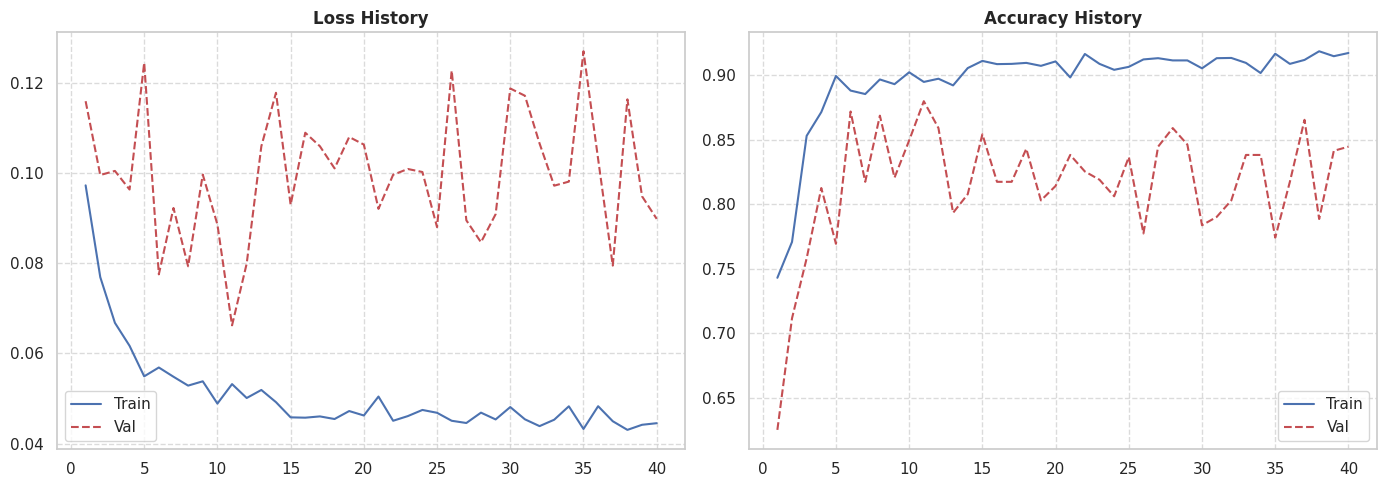


📊 2. Đang chạy kiểm thử (Chờ xíu)...


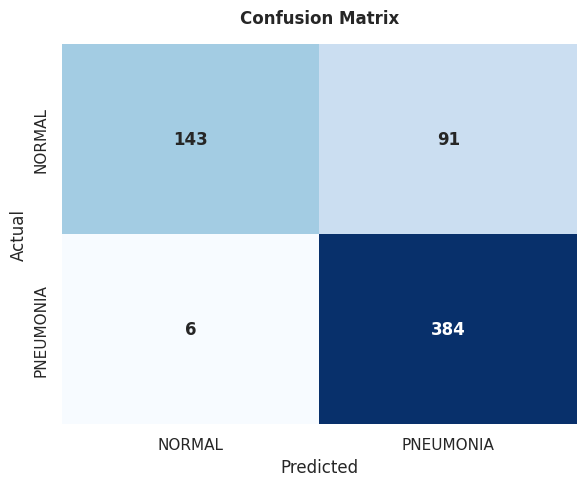


📊 3. Tạo bảng báo cáo chuẩn Paper...


/tmp/ipython-input-2640781596.py:121: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_report = df_report.applymap(lambda x: f"{x:.4f}")


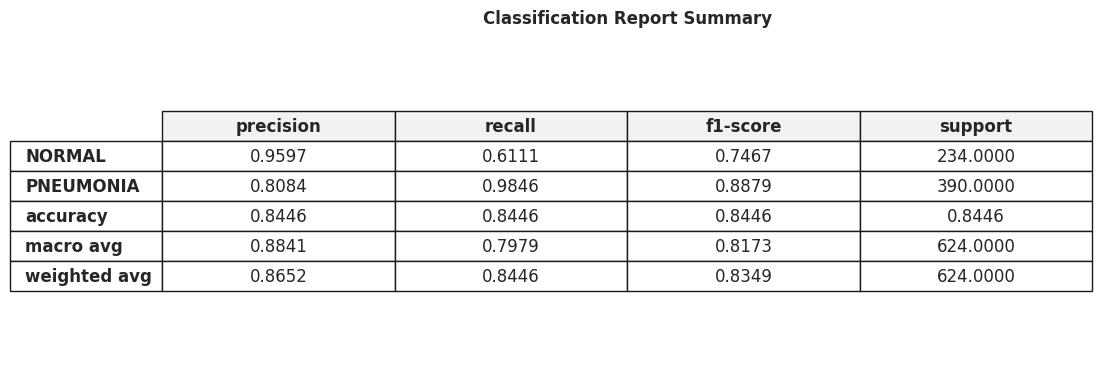


📊 4. Vẽ biểu đồ so sánh...


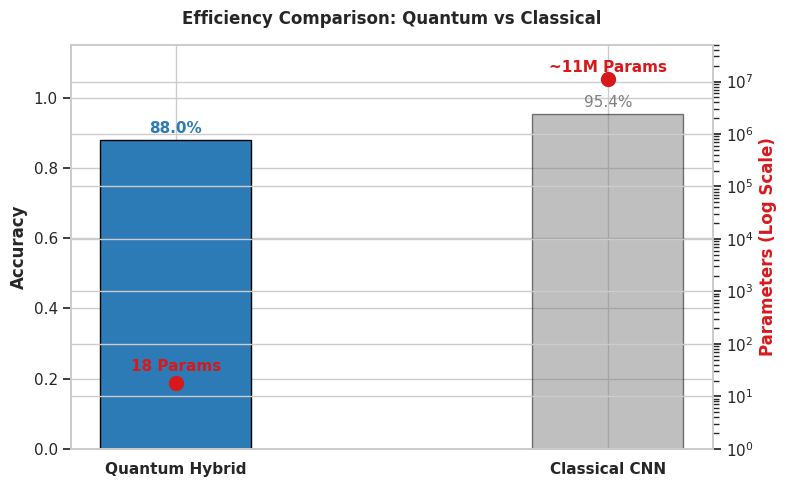

In [ ]:
# ==============================================================================
# CELL 4: XUẤT KẾT QUẢ & VẼ BẢNG CHUẨN PAPER (CLEAN STYLE)
# ==============================================================================

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import models, datasets, transforms
import pennylane as qml

# 1. CẤU HÌNH LẠI MÔI TRƯỜNG
device = torch.device("cpu") # Chạy CPU để lấy kết quả
print(f"🚀 Chế độ xuất báo cáo (Report Mode) trên: {device}")

# Style chung cho biểu đồ (Vẫn dùng seaborn cho biểu đồ đường/cột)
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})

# Đường dẫn file
checkpoint_path = '/content/drive/MyDrive/ReseacherAboutQuantumComputer/Checkpoints/hybrid_advanced_checkpoint.pth'
data_dir = '/content/drive/MyDrive/ReseacherAboutQuantumComputer/1-Article/Train/chest_xray/chest_xray'

# 2. ĐỊNH NGHĨA LẠI MODEL
n_qubits = 4; n_layers = 2
dev = qml.device("default.mixed", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net(inputs, weights_y, weights_z):
    for _ in range(2):
        scaled_inputs = torch.pi * torch.tanh(inputs)
        qml.AngleEmbedding(scaled_inputs, wires=range(n_qubits), rotation='X')
        for layer in range(n_layers):
            for q in range(n_qubits):
                qml.RY(weights_y[layer, q], wires=q)
                qml.RZ(weights_z[layer, q], wires=q)
            for q in range(n_qubits-1): qml.CNOT(wires=[q, q+1])
            qml.CNOT(wires=[n_qubits-1, 0])
        qml.DepolarizingChannel(0.01, wires=0)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumTransferModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(weights=None)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, n_qubits)
        weight_shapes = {"weights_y": (n_layers, n_qubits), "weights_z": (n_layers, n_qubits)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_net, weight_shapes)
        self.classifier = nn.Linear(n_qubits, 2)
    def forward(self, x):
        return self.classifier(self.quantum_layer(self.base_model(x)))

# 3. NẠP DỮ LIỆU & VẼ HÌNH
if os.path.isfile(checkpoint_path):
    print(f"🔄 Đang đọc file checkpoint: {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model_hybrid = QuantumTransferModel().to(device)
        model_hybrid.load_state_dict(checkpoint['state_dict'])
        model_hybrid.eval()

        history = checkpoint.get('history', {})
        best_acc = checkpoint.get('best_acc', 0.0)

        print(f"✅ ĐÃ NẠP THÀNH CÔNG! (Best Acc: {best_acc:.2%})")

        # --- 1. LEARNING CURVE ---
        if 'train_loss' in history and len(history['train_loss']) > 0:
            print("\n📊 1. Vẽ biểu đồ Learning Curve...")
            epochs = range(1, len(history['train_loss']) + 1)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
            ax1.plot(epochs, history['train_loss'], 'b-', label='Train')
            ax1.plot(epochs, history['val_loss'], 'r--', label='Val')
            ax1.set_title('Loss History', fontweight='bold'); ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.7)
            ax2.plot(epochs, history['train_acc'], 'b-', label='Train')
            ax2.plot(epochs, history['val_acc'], 'r--', label='Val')
            ax2.set_title('Accuracy History', fontweight='bold'); ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout(); plt.show()

        # --- 2. CHẠY TEST ---
        print("\n📊 2. Đang chạy kiểm thử (Chờ xíu)...")
        transform = transforms.Compose([
            transforms.Resize(256), transforms.CenterCrop(224),
            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        test_set = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)

        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model_hybrid(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())
        class_names = test_set.classes

        # --- 3. VẼ CONFUSION MATRIX ---
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    annot_kws={"size": 12, "weight": "bold"}, cbar=False)
        plt.title('Confusion Matrix', fontweight='bold', pad=15)
        plt.xlabel('Predicted'); plt.ylabel('Actual')
        plt.tight_layout(); plt.show()

        # --- 4. VẼ BẢNG CLASSIFICATION REPORT (CHUẨN KHOA HỌC) ---
        print("\n📊 3. Tạo bảng báo cáo chuẩn Paper...")

        # Lấy dữ liệu
        report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        df_report = pd.DataFrame(report_dict).transpose()

        # Format số liệu (4 chữ số thập phân)
        df_report = df_report.applymap(lambda x: f"{x:.4f}")

        # Vẽ bảng bằng Matplotlib Table (Trắng đen, tối giản)
        fig, ax = plt.subplots(figsize=(10, 4)) # Kích thước bảng
        ax.axis('tight')
        ax.axis('off') # Tắt trục tọa độ

        # Tạo bảng
        table = ax.table(cellText=df_report.values,
                         colLabels=df_report.columns,
                         rowLabels=df_report.index,
                         cellLoc='center',
                         loc='center')

        # Tinh chỉnh thẩm mỹ
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.8) # Tăng chiều cao dòng cho thoáng

        # Đậm tiêu đề cột và hàng
        for (row, col), cell in table.get_celld().items():
            if row == 0 or col == -1:
                cell.set_text_props(weight='bold')
            # Thêm màu nền nhẹ cho tiêu đề (Optional - xám rất nhạt)
            if row == 0:
                cell.set_facecolor('#f2f2f2')

        plt.title('Classification Report Summary', fontweight='bold', y=1.05)
        plt.show()

        # --- 5. COMPARATIVE PLOT ---
        print("\n📊 4. Vẽ biểu đồ so sánh...")
        current_acc = best_acc
        sota_acc = 0.9542
        fig, ax1 = plt.subplots(figsize=(8, 5))
        color1 = '#2c7bb6'
        ax1.bar([0], [current_acc], width=0.35, label='Ours', color=color1, edgecolor='black')
        ax1.bar([1], [sota_acc], width=0.35, label='ResNet-18', color='gray', alpha=0.5, edgecolor='black')
        ax1.set_xticks([0, 1]); ax1.set_xticklabels(['Quantum Hybrid', 'Classical CNN'], fontweight='bold')
        ax1.set_ylabel('Accuracy', fontweight='bold'); ax1.set_ylim(0, 1.15)
        ax1.text(0, current_acc+0.02, f"{current_acc:.1%}", ha='center', fontweight='bold', color=color1)
        ax1.text(1, sota_acc+0.02, f"{sota_acc:.1%}", ha='center', color='gray')

        ax2 = ax1.twinx()
        color2 = '#d7191c'
        ax2.plot([0], [18], marker='o', color=color2, markersize=10, label='Params', linestyle='none')
        ax2.plot([1], [11176512], marker='o', color=color2, markersize=10, linestyle='none')
        ax2.set_yscale('log'); ax2.set_ylabel('Parameters (Log Scale)', color=color2, fontweight='bold')
        ax2.set_ylim(1, 50000000)
        ax2.text(0, 30, "18 Params", ha='center', color=color2, fontweight='bold')
        ax2.text(1, 15000000, "~11M Params", ha='center', color=color2, fontweight='bold')
        plt.title('Efficiency Comparison: Quantum vs Classical', fontweight='bold', pad=15)
        plt.tight_layout(); plt.show()

    except Exception as e:
        print(f"❌ LỖI RỒI: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"❌ KHÔNG TÌM THẤY FILE: {checkpoint_path}")